# Notebook "3_Besoin_3_Application_10_Profils"


## Description

Ce notebook se focalise sur la récupération des données stocké en DB de l'application de la CMB 10 profils sur une période de temps donnée

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Chargement des données et des profils
- III. Affichage des résultats

## Prérequis

### Source de données

Pour que le notebook fonctionne, il est nécessaire que le fichier project_config.yml soit situé au même niveau que ce notebook : ce fichier permet la connexion à la source de données.

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- psycopg2
- sqlachemy
- sklearn
- numpy
- yaml
- matplotlib

# I - Import des bibliothèques

In [1]:
# handling postgres database
import psycopg2
import pandas.io.sql as sqlio
import pandas as pd 
from sqlalchemy import create_engine
from io import StringIO
from sklearn.linear_model import Lasso
from sklearn import metrics
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yaml
from IPython.display import clear_output

Profiles = ['HOA',
    'BBOA',
    'OPOA/OBBOA',
    'BSOA (marine)',
    'BSOA (isoprene)',
    'ASOA (nitro-PAHs)',
    'ASOA (oxy-PAHs)',
    'ASOA (phenolic compounds oxidation)',
    'ASOA (toluene oxidation)',
    'SOA (unknown)']

# II - Chargement des données et des profils

## II.a Recherche des identifiants de connexion

In [2]:
with open(r'.\project_config.yml') as file:
    dbInfo = yaml.load(file, Loader=yaml.FullLoader)
    HOSTNAME = dbInfo["project-database"]["hostname"]
    DATABASE = dbInfo["project-database"]["name"]
    USER = dbInfo["project-database"]["user"]
    PASSWORD = dbInfo["project-database"]["password"]
    PORT = "5432"

## II.b Recherche des profils dans la DB

In [3]:
df = pd.read_excel('./pmf_profiles.xlsx', engine='openpyxl')

df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'Unnamed: 1': 'amus'}, inplace=True)
df = df[["amus"] + Profiles]
pro = df.columns[1:]

## II.c Sélection des données

In [4]:
## SELECTION DE LA DATE
start_date = '2015-03-07'
end_date = '2015-03-21'

# start_date = '2017-01-01'
# end_date = '2019-01-01'

In [5]:
# query = f"""
#     SELECT *
#     FROM public.regressor_results
#     WHERE model = 'LASSO_10_full' AND date >= '{start_date}' AND date <= '{end_date}'
#     ORDER BY date
# """
query = f"""
    SELECT *
    FROM public.regressor_results
    WHERE model = 'LASSO_10_full'
    ORDER BY date
"""
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
df_result = sqlio.read_sql_query(query, connection)
connection.close()

In [6]:
list_date = pd.unique(df_result["date"])
df_final = pd.DataFrame(data=[], columns=["date"])
df_final['date'] = list_date

In [7]:
for pro in Profiles:
    result_inter = []
    aux = df_result[['date', 'contribution']][df_result['profile'] == pro]
    aux = aux.sort_values(by=["date"])
    df_final[pro] = aux['contribution'].values


# III. Affichage des résultats

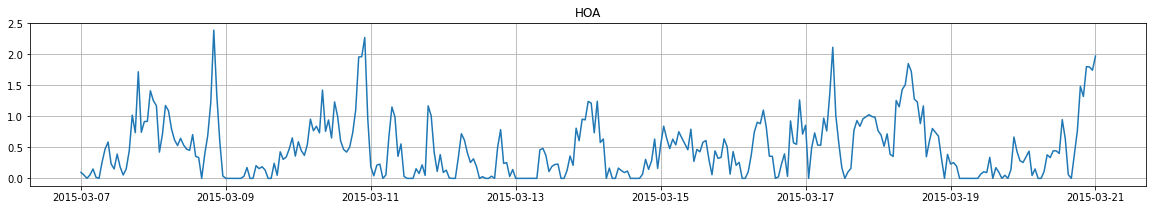

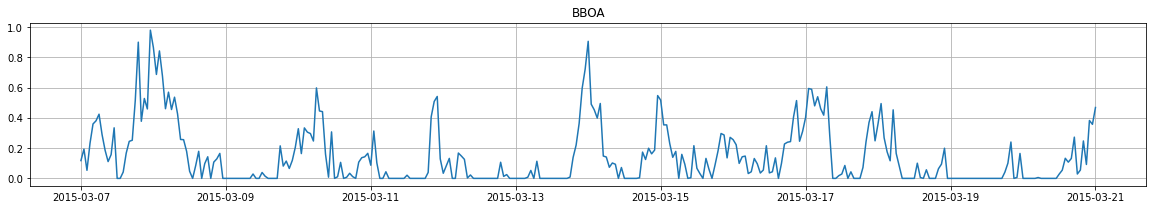

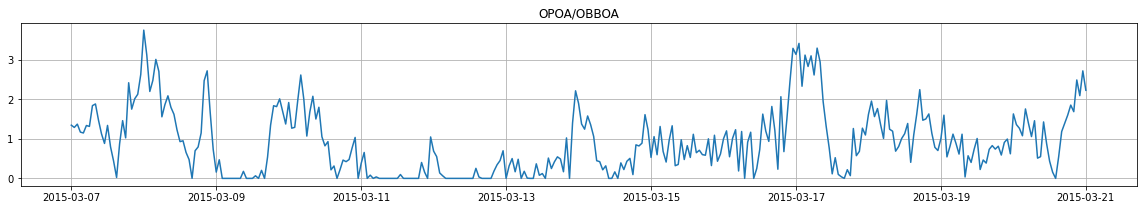

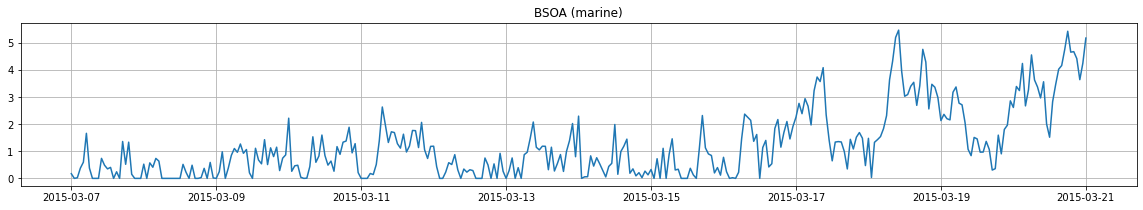

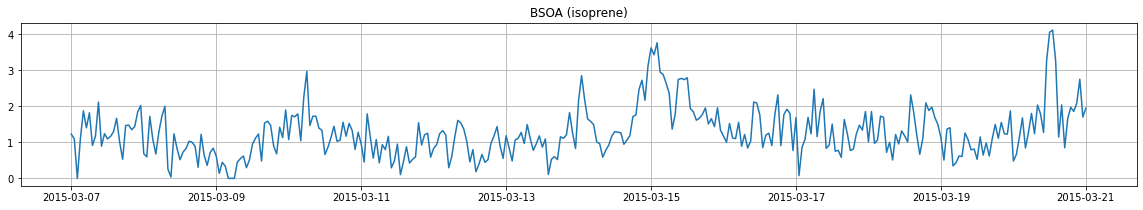

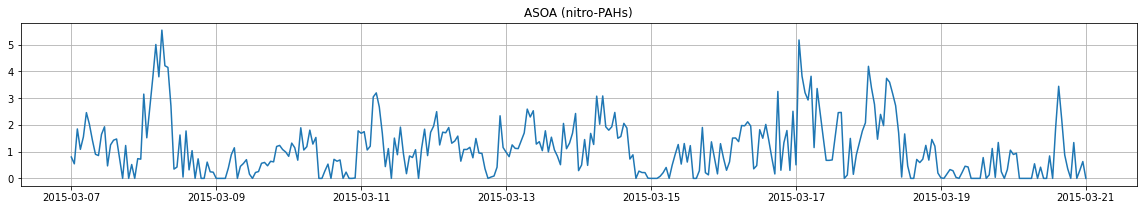

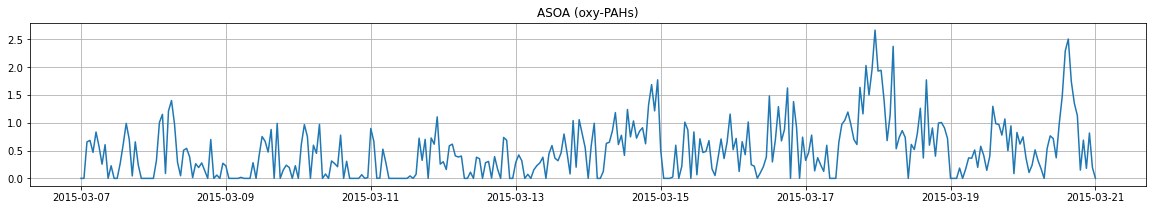

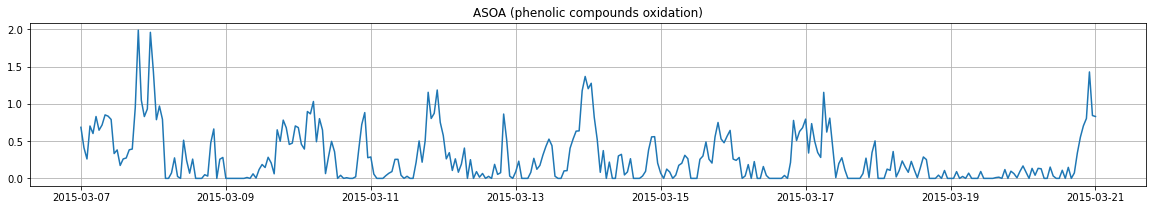

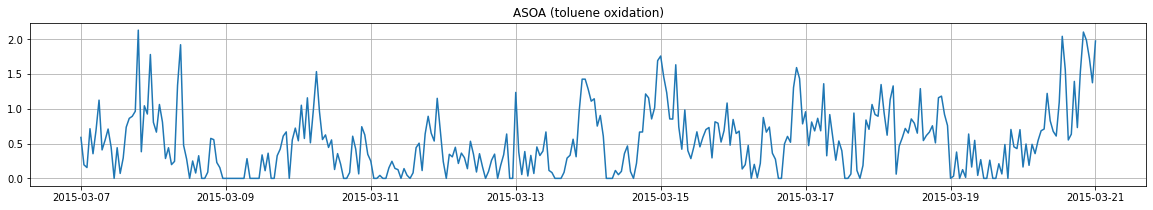

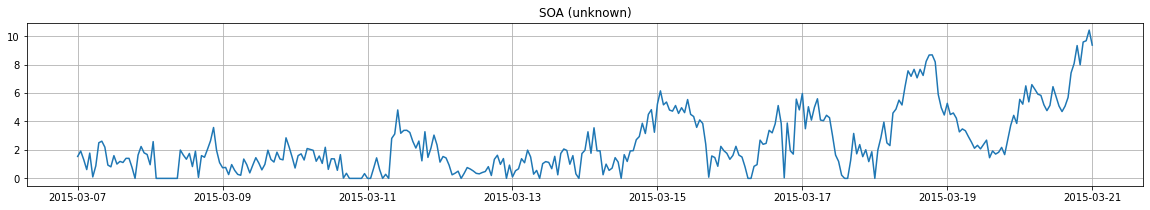

In [114]:
plt.rcParams["figure.figsize"] = (20,3)
for pro in Profiles:
#     fig.size(7,10)
    plt.title(pro)
    plt.plot(df_final['date'].values,df_final[pro].values)
    plt.grid()
    plt.show()

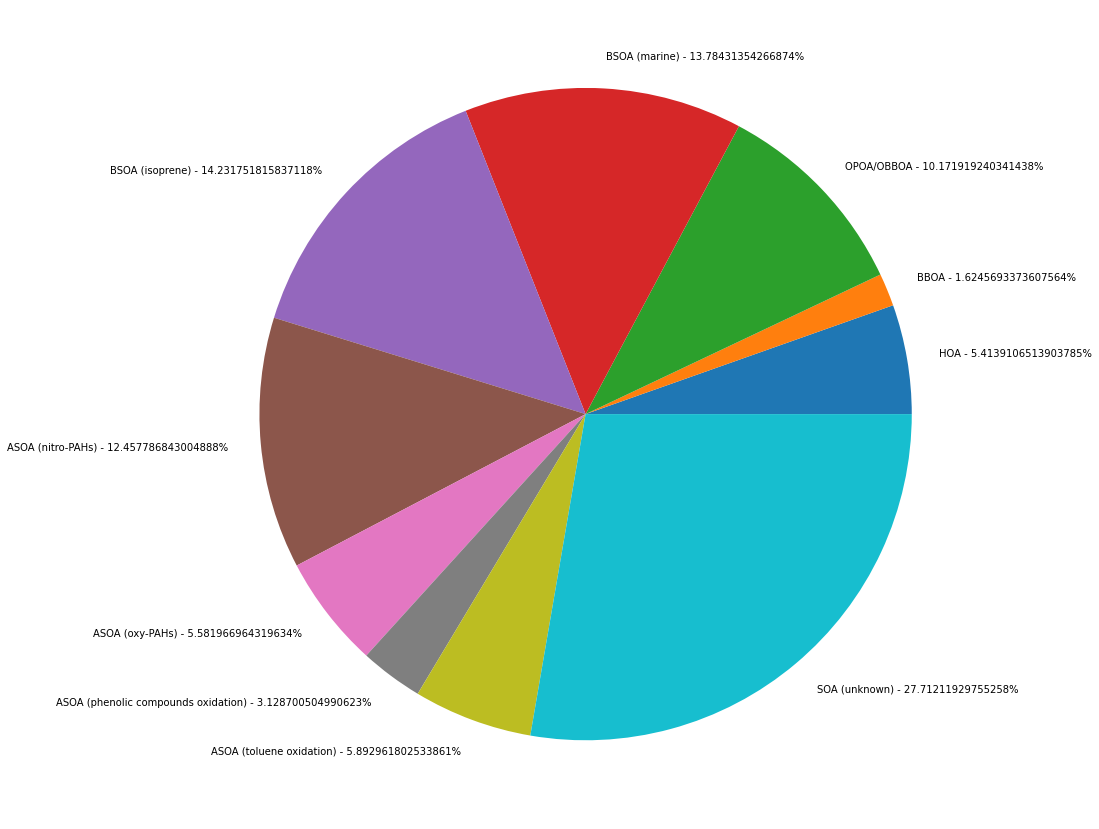

In [115]:
data_pie = np.mean(df_final)
proportion = data_pie * 100 / np.sum(data_pie)
plt.rcParams["figure.figsize"] = (15,15)
plt.pie(proportion, labels=[profil + " - " + str(proportion[i]) + "%" for i, profil in enumerate(Profiles)])
plt.show() 

In [116]:
a = df_final[Profiles].values
result_per_profil = [ [ a[date][i] for date in range(len(a))] for i, pro in enumerate(Profiles)]

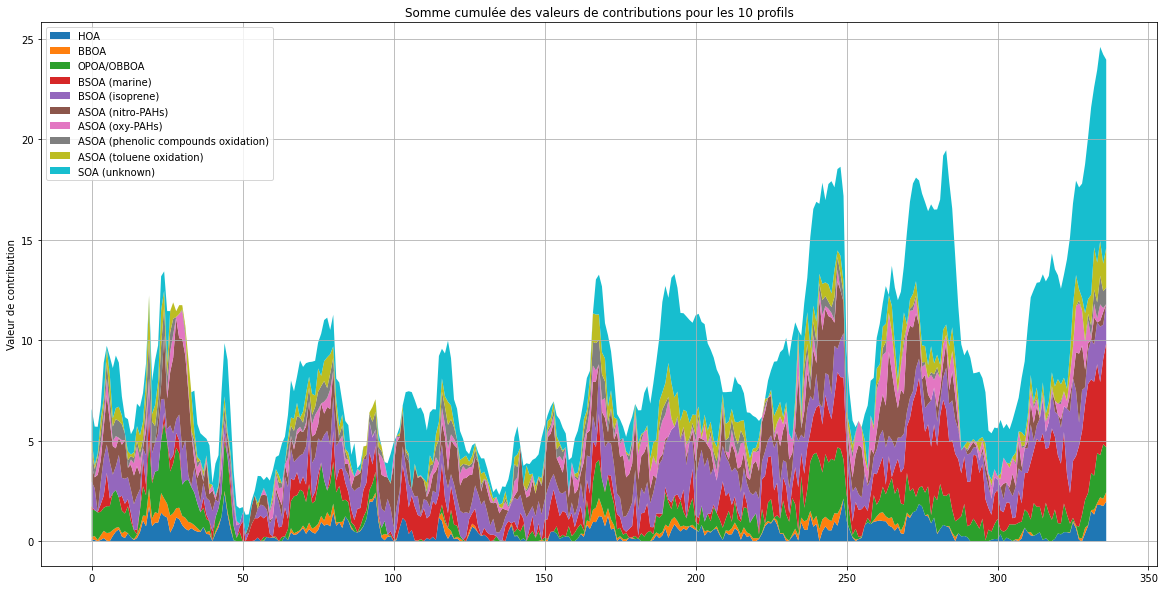

In [117]:
cumsum_contribution = np.cumsum(result_per_profil, axis=0)
plt.rcParams["figure.figsize"] = (20, 10)
for n, prof in enumerate(Profiles):
    # plt.plot(cumsum_contribution[n])
    if n == 0:
        plt.fill_between(range(len(cumsum_contribution[0])), cumsum_contribution[n], 0, label=prof)
    else:
        plt.fill_between(range(len(cumsum_contribution[0])), cumsum_contribution[n], cumsum_contribution[n-1], label=prof)
plt.grid()
plt.title("Somme cumulée des valeurs de contributions pour les 10 profils")
plt.ylabel("Valeur de contribution")
plt.legend(loc='upper left')
plt.show()

In [9]:
df_final.to_csv("cmb_10_all_times.csv", sep=";")